<a href="https://colab.research.google.com/github/TemrinaDarya/turbines-2022/blob/hw3/TemrinaDarya_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*  P0= 16,7 МПа
*  t0= 520 ˚C
*  Р2 = 14,5 МПа
*  Dcр = 0.892 м
*  Dкорня = 0.8 м
*  ρср = 0.2
*  αср = 13˚
*  β2 = β1 - 5˚
*  φ = 0,97
*  ψ = 0,935
*  n = 50 1/c
*  Степень реактивности по высоте распределена по формуле: 
(1-ρ)/(1-ρср)=(R/Rcp)^-1.7 
*  Углол  распределен по высоте по формуле: 
α1/α1ρ=(R/Rcp)^2

In [1]:
!pip install iapws

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 5.4 MB/s 
  Created wheel for iapws: filename=iapws-1.5.3-py3-none-any.whl size=114282 sha256=dadd26e4680f93254acc417e694a003416428559d846713d2e53125265a9dcde
  Stored in directory: /root/.cache/pip/wheels/66/b4/cb/ef55293a897beaad4f10f2fc5d7f9e43bc29170568c52850c2
Successfully built iapws


In [2]:
# Импорты
from pyparsing.helpers import null_debug_action
import iapws
from iapws import IAPWS97 as gas
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
# Константы
MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

In [4]:
def heat_drop(p_0, t_0, p_2):
    inlet_point = gas(P=p_0 * unit, T=t_0)
    outlet_point = gas(P=p_2 * unit, s=inlet_point.s)
    theoretical_heat_drop = inlet_point.h - outlet_point.h
    return theoretical_heat_drop


def stator_and_rotor(theoretical_heat_drop, degree_of_reaction):
    stator_heat_drop = theoretical_heat_drop * (1 - degree_of_reaction)
    rotor_heat_drop = theoretical_heat_drop * degree_of_reaction
    return stator_heat_drop, rotor_heat_drop


def compute_speed(stator_heat_drop, avg_diameter, alpha_1_deg, rotor_heat_drop):
    fi = 0.97
    psi = 0.935
    rotation_speed = 50
    c_1t = (2 * 1000 * stator_heat_drop) ** 0.5
    c_1 = c_1t * fi
    u = math.pi * avg_diameter * rotation_speed
    sin_alpha_1 = math.sin(math.radians(alpha_1_deg))
    cos_alpha_1 = math.cos(math.radians(alpha_1_deg))
    w_1 = (c_1 ** 2 + u ** 2 - 2 * c_1 * u * cos_alpha_1) ** 0.5
    w_2t = (w_1 ** 2 + 2 * rotor_heat_drop * 1000) ** 0.5
    w_2 = w_2t * psi
    beta_1 = math.atan(sin_alpha_1 / (cos_alpha_1 - u / c_1))
    beta_1_deg = math.degrees(beta_1)
    beta_2_deg = beta_1_deg - delta_beta_deg
    sin_beta_2 = math.sin(math.radians(beta_2_deg))
    cos_beta_2 = math.cos(math.radians(beta_2_deg))
    return c_1, cos_alpha_1, sin_alpha_1, u, w_2, cos_beta_2, sin_beta_2


def get_degree_of_reaction(R, R_avg, degree_of_reaction_avg):
    degree_of_reaction = (1 / ((R / R_avg) ** 1.7)) * (degree_of_reaction_avg - 1) + 1
    return degree_of_reaction


def alpha_1(R, R_avg, alpha_1_deg_avg):
    alpha_1_deg = ((R / R_avg) ** 2) * alpha_1_deg_avg
    return alpha_1_deg


def compute_points(c_1, cos_alpha_1, sin_alpha_1, u, w_2, cos_beta_2, sin_beta_2):
    c1_plot = [[0, -c_1 * cos_alpha_1], [0, -c_1 * sin_alpha_1]]
    u1_plot = [[-c_1 * cos_alpha_1, -c_1 * cos_alpha_1 + u], [-c_1 * sin_alpha_1, -c_1 * sin_alpha_1]]
    w1_plot = [[0, -c_1 * cos_alpha_1 + u], [0, -c_1 * sin_alpha_1]]
    w2_plot = [[0, w_2 * cos_beta_2], [0, -w_2 * sin_beta_2]]
    u2_plot = [[w_2 * cos_beta_2, w_2 * cos_beta_2 - u], [-w_2 * sin_beta_2, -w_2 * sin_beta_2]]
    c2_plot = [[0, w_2 * cos_beta_2 - u], [0, -w_2 * sin_beta_2]]
    return c1_plot, u1_plot, w1_plot, w2_plot, u2_plot, c2_plot


def plot(c1_plot, u1_plot, w1_plot, w2_plot, u2_plot, c2_plot):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(c1_plot[0], c1_plot[1], label='C_1', c='red')
    ax.plot(u1_plot[0], u1_plot[1], label='u_1', c='blue')
    ax.plot(w1_plot[0], w1_plot[1], label='W_1', c='green')
    ax.plot(c2_plot[0], c2_plot[1], label='C_2', c='red')
    ax.plot(u2_plot[0], u2_plot[1], label='u_2', c='blue')
    ax.plot(w2_plot[0], w2_plot[1], label='W_2', c='green')
    ax.set_title("Треугольник скоростей", )
    ax.legend()
    ax.grid()


def calculate_all(avg_diameter, R, R_avg, degree_of_reaction_avg, alpha_1_deg_avg, theoretical_heat_drop):
    degree_of_reaction = get_degree_of_reaction(R, R_avg, degree_of_reaction_avg)
    alpha_1_deg = alpha_1(R, R_avg, alpha_1_deg_avg)
    stator_heat_drop, rotor_heat_drop = stator_and_rotor(theoretical_heat_drop, degree_of_reaction)
    c_1, cos_alpha_1, sin_alpha_1, u, w_2, cos_beta_2, sin_beta_2 = compute_speed(
        stator_heat_drop, avg_diameter, alpha_1_deg, rotor_heat_drop)
    c1_plot, u1_plot, w1_plot, w2_plot, u2_plot, c2_plot = compute_points(
        c_1, cos_alpha_1, sin_alpha_1, u, w_2, cos_beta_2, sin_beta_2)
    plot(c1_plot, u1_plot, w1_plot, w2_plot, u2_plot, c2_plot)


In [5]:
# Начальные параметры
p_0 = 16.7 * MPa
t_0 = to_kelvin(520)
p_2 = 14.5 * MPa
avg_diameter = 0.892
diameter_inlet = 0.8
degree_of_reaction_avg = 0.2
alpha_1_deg_avg = 13
delta_beta_deg = 5
fi = 0.97
psi = 0.935
rotation_speed = 50
diameter_outlet = avg_diameter * 2 - diameter_inlet
n = 11
step = (diameter_outlet - diameter_inlet) / n
diam = list(np.arange(diameter_inlet, diameter_outlet, step))

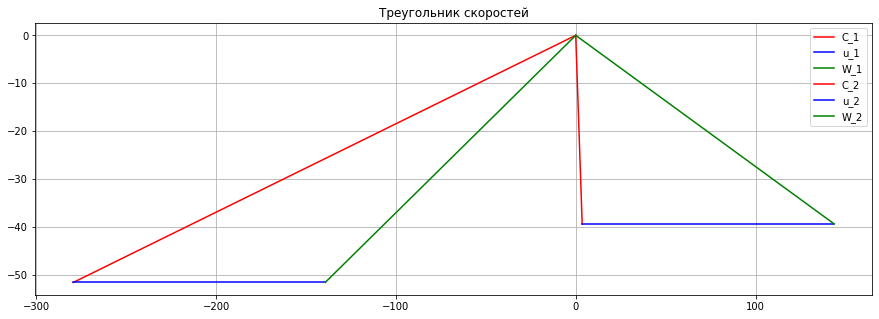

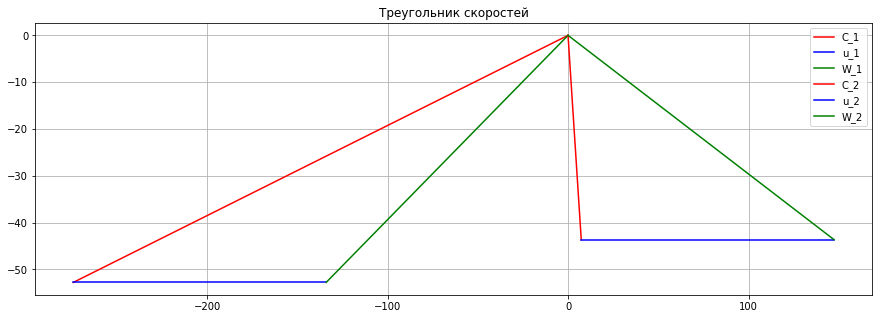

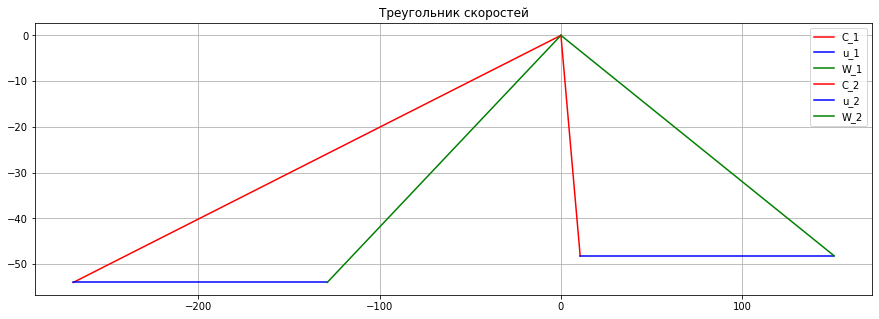

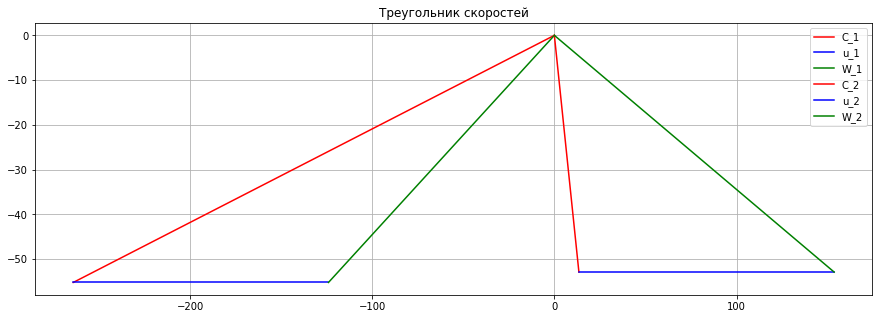

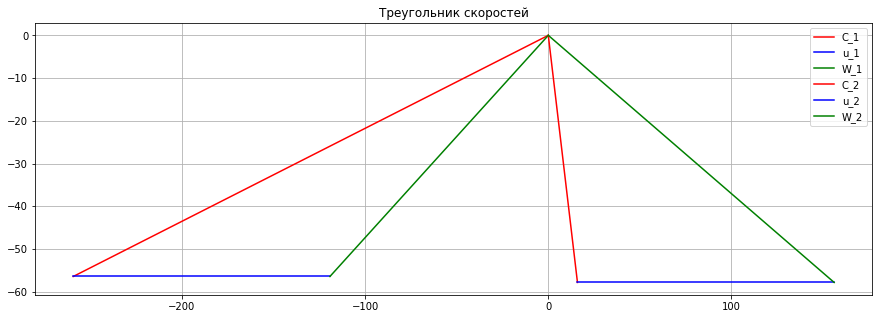

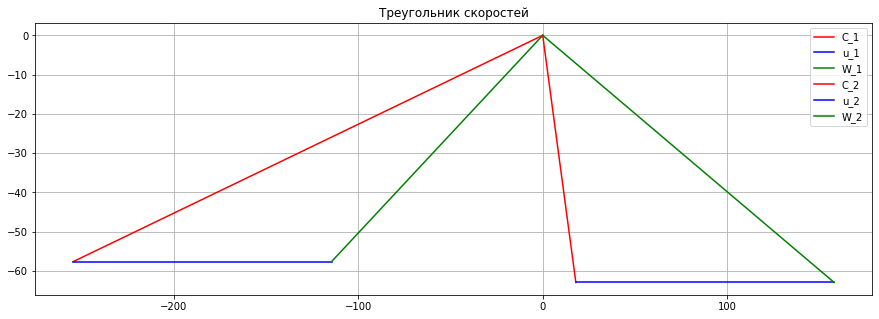

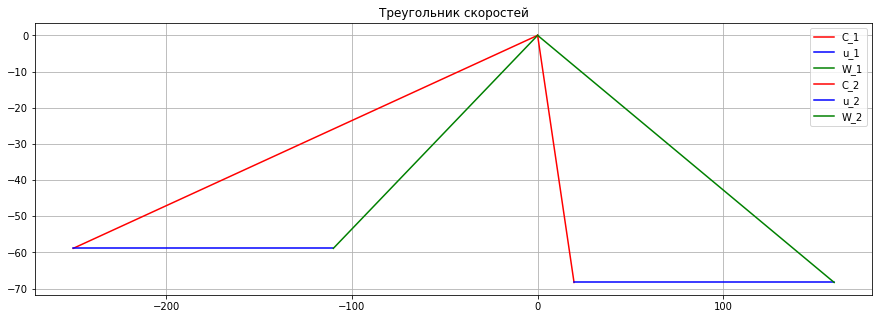

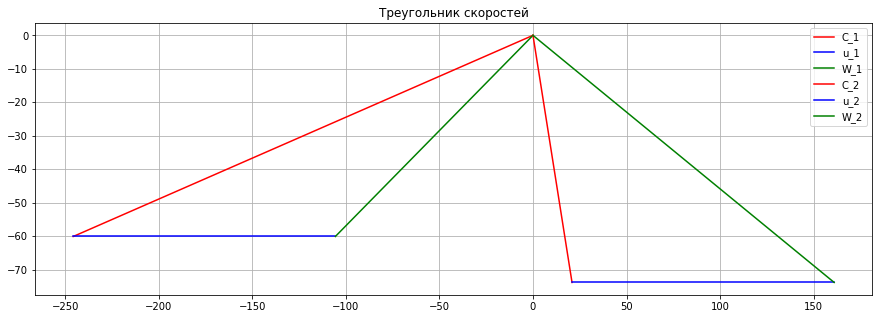

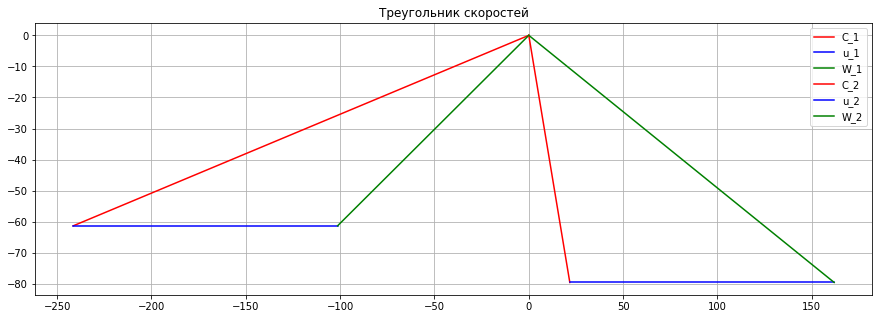

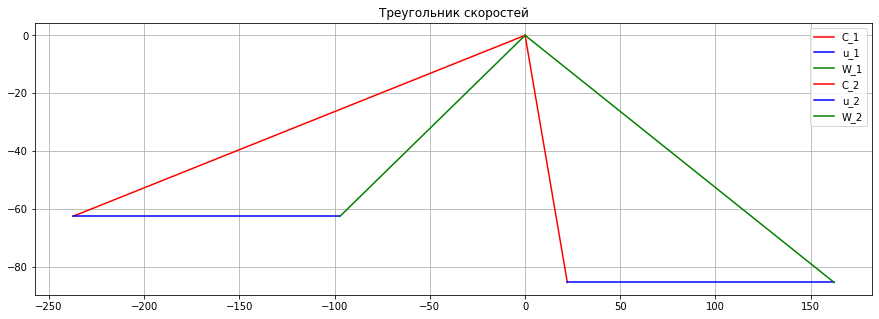

In [6]:
theoretical_heat_drop = heat_drop(p_0, t_0, p_2)
for i in range(len(diam) - 1):
    R = diam[i] / 2
    R_avg = avg_diameter / 2
    calculate_all(avg_diameter, R, R_avg, degree_of_reaction_avg, alpha_1_deg_avg, theoretical_heat_drop)
